# **LSTM - Mindspore**

### **Installing Libraries**

In [ ]:
!pip install mindspore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.0/962.0 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip uninstall -y numpy

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


In [ ]:
!pip install numpy==1.26.4 --force-reinstall

  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install tensorflow

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os
import mindspore as ms
from mindspore import context, Tensor, dtype as mstype
from mindspore.nn import (
    Embedding, LSTM, Dropout, Dense, ReLU,
    SoftmaxCrossEntropyWithLogits, Adam
)
from mindspore.train import Model
from mindspore.train.callback import (
    CheckpointConfig, ModelCheckpoint, EarlyStopping, LossMonitor
)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
import kagglehub

path = kagglehub.dataset_download("irfanakbarihabibi/food-ingredients-dataset-with-halal-label")

100%|██████████| 1.98M/1.98M [00:00<00:00, 87.9MB/s]

Extracting files...


In [ ]:
print("MindSpore version:", ms.__version__)

MindSpore version: 2.5.0


In [ ]:
from mindspore import context
device = context.get_context("device_target")
print("Current device target:", device)

Current device target: CPU


### **Data Analysis**

In [ ]:
csv_path = os.path.join(path, 'cleaned_dataset.csv')
df = pd.read_csv(csv_path, encoding='latin-1')

df.head()

,text,label
0,vegetable oil,halal
1,beef stock contains less than of mirepoix carr...,halal
2,clam stock potatoes clams cream vegetable oil ...,haram
3,water cream broccoli celery vegetable oil corn...,haram
4,chicken stock contains less than of yeast extr...,halal


In [ ]:
df['text'][3]

'water cream broccoli celery vegetable oil corn canola andor soybean modified food starch cheddar cheese cheddar cheese cultured milk salt enzymes whey salt sodium phosphate contains less than of butter parmesan and cheddar cheese milk cultures salt enzymes wheat flour salt potatoes onions soy protein concentrate roasted garlic annatto extract for color soy lecithin driedcontains wheat milk soy'

In [ ]:
mask = df['text'].str.contains(r'\blard\b', case=False, na=False)
lard_rows = df[mask]
print(lard_rows)

                                                   text  label
241   water pinto beans soybean oil onion iodized sa...  haram
721   water black beans soybean oil onion salt pork ...  haram
722   water pinto beans soybean oil onion salt pork ...  haram
723   prepared beans water contains or less lard sal...  haram
729   lard greens water sugar salt minced onion hydr...  haram
...                                                 ...    ...
5668  water runner bean pork meat smoked pork bacon ...  haram
5698  filling gravy and sausage gravy water cream mo...  haram
5725  enriched durum flour wheat flour niacin iron t...  haram
8703  baked chocolate pie dough enriched wheat flour...  haram
9529  cooked jasmine rice water white rice seasoned ...  haram

[71 rows x 2 columns]


In [ ]:
contains_numbers = df['text'].astype(str).str.contains(r'\d', na=False)
rows_with_numbers = df[contains_numbers]
print(rows_with_numbers)

Empty DataFrame
Columns: [text, label]
Index: []


In [ ]:
df.isnull().sum()

,0
text,0
label,0


In [ ]:
text_column = 'text'
label_column = 'label'

df = df.reset_index(drop=True)

In [ ]:
print(df[label_column].value_counts())

label
halal    21826
haram    17961
Name: count, dtype: int64


In [ ]:
y = df[label_column].apply(lambda x: 0 if x.lower() == 'halal' else 1)
class_counts = y.value_counts()

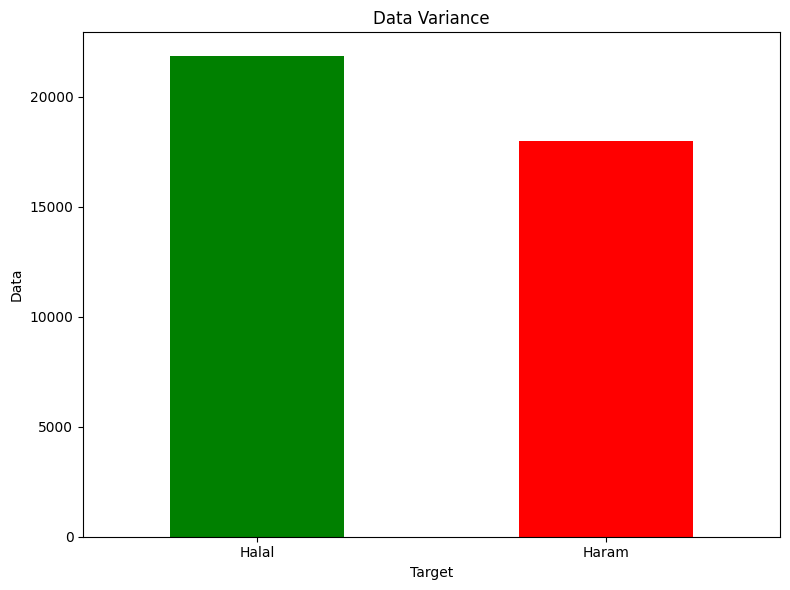

In [ ]:
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['green', 'red'])
plt.title('Data Variance')
plt.xlabel('Target')
plt.ylabel('Data')
plt.xticks([0, 1], ['Halal', 'Haram'], rotation=0)
plt.tight_layout()

plt.savefig('class_distribution.png', dpi=300)

# Show the plot
plt.show()


### **Tokenizer**

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df[text_column])

In [ ]:
X = tokenizer.texts_to_sequences(df[text_column])
X = pad_sequences(X).astype(np.int32)
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

y = LabelEncoder().fit_transform(y).astype(np.int32)

### **Split**

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

### **Make Dataset**

In [ ]:
def make_dataset(X_arr, y_arr, batch_size=32, shuffle=True):
    ds = ms.dataset.NumpySlicesDataset(
        {"data": X_arr, "label": y_arr}, shuffle=shuffle
    )
    return ds.batch(batch_size)

train_dataset = make_dataset(X_train, y_train)
val_dataset   = make_dataset(X_val,   y_val,   shuffle=False)
test_dataset  = make_dataset(X_test,  y_test,  shuffle=False)

In [ ]:
class LSTMClassifier(ms.nn.Cell):
    def __init__(self, vocab_size, embed_dim, hidden1, hidden2, num_classes):
        super().__init__()
        self.embedding = Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm1     = LSTM(embed_dim, hidden1, batch_first=True)
        self.drop1     = Dropout(0.2)
        self.lstm2     = LSTM(hidden1, hidden2, batch_first=True)
        self.drop2     = Dropout(0.2)
        self.fc1       = Dense(hidden2, 32)
        self.relu      = ReLU()
        self.fc2       = Dense(32, num_classes)

    def construct(self, x):
        x = self.embedding(x)             # (B, L, E)
        x, _ = self.lstm1(x)              # (B, L, H1)
        x = self.drop1(x)
        x, _ = self.lstm2(x)              # (B, L, H2)
        x = self.drop2(x)

        batch_size=x.shape[0]
        seq_len=x.shape[1]
        last_time_step = x[:, seq_len-1, :]

        x = self.fc1(last_time_step)      # (B, 32)
        x = self.relu(x)
        x = self.fc2(x)                   # (B, num_classes)
        return x

vocab_size = len(tokenizer.word_index) + 1
model_net  = LSTMClassifier(
    vocab_size=vocab_size,
    embed_dim=50,
    hidden1=100,
    hidden2=50,
    num_classes=2
)

[WARNING] ME(2540:140657341231104,MainProcess):2025-04-24-12:06:48.661.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(2540:140657341231104,MainProcess):2025-04-24-12:06:48.694.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.


In [ ]:
loss_fn = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
optimizer = Adam(model_net.trainable_params(), learning_rate=1e-4)

model = Model(model_net, loss_fn=loss_fn, optimizer=optimizer, metrics={"accuracy"})

# 7) CALLBACKS: checkpoint + early stopping + loss monitor
ckpt_config = CheckpointConfig(save_checkpoint_steps=100, keep_checkpoint_max=1)
ckpt_cb     = ModelCheckpoint(prefix="best_model", directory="./", config=ckpt_config)
early_cb    = EarlyStopping(monitor="loss", patience=5, mode="max")
loss_cb     = LossMonitor()

In [ ]:
model.train(
    epoch=10,
    train_dataset=train_dataset,
    callbacks=[ckpt_cb, early_cb, loss_cb],
    dataset_sink_mode=False
)

res = model.eval(test_dataset, dataset_sink_mode=False)
print(f"Test set accuracy: {res['accuracy']:.4f}")

epoch: 1 step: 1, loss is 0.7065979242324829
epoch: 1 step: 2, loss is 0.7237032055854797
epoch: 1 step: 3, loss is 0.7048289775848389
epoch: 1 step: 4, loss is 0.7035069465637207
epoch: 1 step: 5, loss is 0.7069597840309143
epoch: 1 step: 6, loss is 0.7051082253456116
epoch: 1 step: 7, loss is 0.6951498985290527
epoch: 1 step: 8, loss is 0.6971979737281799
epoch: 1 step: 9, loss is 0.6888637542724609
epoch: 1 step: 10, loss is 0.7102413177490234
epoch: 1 step: 11, loss is 0.7140167355537415
epoch: 1 step: 12, loss is 0.7358464598655701
epoch: 1 step: 13, loss is 0.6869316101074219
epoch: 1 step: 14, loss is 0.7150680422782898
epoch: 1 step: 15, loss is 0.6937225461006165
epoch: 1 step: 16, loss is 0.7101569771766663
epoch: 1 step: 17, loss is 0.7023451924324036
epoch: 1 step: 18, loss is 0.6817297339439392
epoch: 1 step: 19, loss is 0.704456090927124
epoch: 1 step: 20, loss is 0.6949878931045532
epoch: 1 step: 21, loss is 0.715787947177887
epoch: 1 step: 22, loss is 0.6903873085975647

[WARNING] ME(1671:136248148721664,MainProcess):2025-04-19-14:19:22.230.000 [mindspore/train/callback/_early_stop.py:221] Early stopping is conditioned on accuracy, which is not available. Available choices are: {'loss'}


epoch: 2 step: 1, loss is 0.39881014823913574
epoch: 2 step: 2, loss is 0.19867396354675293
epoch: 2 step: 3, loss is 0.5148831605911255
epoch: 2 step: 4, loss is 0.2081117331981659
epoch: 2 step: 5, loss is 0.19081637263298035
epoch: 2 step: 6, loss is 0.143000528216362
epoch: 2 step: 7, loss is 0.29270055890083313
epoch: 2 step: 8, loss is 0.3898705840110779
epoch: 2 step: 9, loss is 0.42192256450653076
epoch: 2 step: 10, loss is 0.3258231580257416
epoch: 2 step: 11, loss is 0.23715050518512726
epoch: 2 step: 12, loss is 0.2735876142978668
epoch: 2 step: 13, loss is 0.3026379942893982
epoch: 2 step: 14, loss is 0.30240654945373535
epoch: 2 step: 15, loss is 0.4172680974006653
epoch: 2 step: 16, loss is 0.14388228952884674
epoch: 2 step: 17, loss is 0.23629628121852875
epoch: 2 step: 18, loss is 0.28162041306495667
epoch: 2 step: 19, loss is 0.45047348737716675
epoch: 2 step: 20, loss is 0.4209933876991272
epoch: 2 step: 21, loss is 0.24537727236747742
epoch: 2 step: 22, loss is 0.234

[WARNING] ME(1671:136248148721664,MainProcess):2025-04-19-15:00:27.993.000 [mindspore/train/callback/_early_stop.py:221] Early stopping is conditioned on accuracy, which is not available. Available choices are: {'loss'}


epoch: 3 step: 1, loss is 0.050761930644512177
epoch: 3 step: 2, loss is 0.042721379548311234
epoch: 3 step: 3, loss is 0.15446273982524872
epoch: 3 step: 4, loss is 0.08598857372999191
epoch: 3 step: 5, loss is 0.03846484050154686
epoch: 3 step: 6, loss is 0.06409306079149246
epoch: 3 step: 7, loss is 0.11355197429656982
epoch: 3 step: 8, loss is 0.13566583395004272
epoch: 3 step: 9, loss is 0.04392684996128082
epoch: 3 step: 10, loss is 0.2177165299654007
epoch: 3 step: 11, loss is 0.18399398028850555
epoch: 3 step: 12, loss is 0.16995030641555786
epoch: 3 step: 13, loss is 0.09828925877809525
epoch: 3 step: 14, loss is 0.02122863382101059
epoch: 3 step: 15, loss is 0.05428694933652878
epoch: 3 step: 16, loss is 0.06423508375883102
epoch: 3 step: 17, loss is 0.14063630998134613
epoch: 3 step: 18, loss is 0.1186385378241539
epoch: 3 step: 19, loss is 0.05218574032187462
epoch: 3 step: 20, loss is 0.0488957054913044
epoch: 3 step: 21, loss is 0.1390858143568039
epoch: 3 step: 22, loss 

[WARNING] ME(1671:136248148721664,MainProcess):2025-04-19-15:40:58.831.000 [mindspore/train/callback/_early_stop.py:221] Early stopping is conditioned on accuracy, which is not available. Available choices are: {'loss'}


epoch: 4 step: 1, loss is 0.14326030015945435
epoch: 4 step: 2, loss is 0.06556695699691772
epoch: 4 step: 3, loss is 0.02545430138707161
epoch: 4 step: 4, loss is 0.034942466765642166
epoch: 4 step: 5, loss is 0.030570806935429573
epoch: 4 step: 6, loss is 0.1527153104543686
epoch: 4 step: 7, loss is 0.06749889999628067
epoch: 4 step: 8, loss is 0.03846844658255577
epoch: 4 step: 9, loss is 0.008204332552850246
epoch: 4 step: 10, loss is 0.008146343752741814
epoch: 4 step: 11, loss is 0.03130723536014557
epoch: 4 step: 12, loss is 0.03214151784777641
epoch: 4 step: 13, loss is 0.05656413361430168
epoch: 4 step: 14, loss is 0.19077695906162262
epoch: 4 step: 15, loss is 0.18567226827144623
epoch: 4 step: 16, loss is 0.1653951108455658
epoch: 4 step: 17, loss is 0.04689908027648926
epoch: 4 step: 18, loss is 0.01780650019645691
epoch: 4 step: 19, loss is 0.03310846909880638
epoch: 4 step: 20, loss is 0.014331369660794735
epoch: 4 step: 21, loss is 0.07002156227827072
epoch: 4 step: 22, 

[WARNING] ME(1671:136248148721664,MainProcess):2025-04-19-16:22:04.560.00 [mindspore/train/callback/_early_stop.py:221] Early stopping is conditioned on accuracy, which is not available. Available choices are: {'loss'}


epoch: 5 step: 1, loss is 0.25834622979164124
epoch: 5 step: 2, loss is 0.020815763622522354
epoch: 5 step: 3, loss is 0.009243713691830635
epoch: 5 step: 4, loss is 0.02028408646583557
epoch: 5 step: 5, loss is 0.02922840788960457
epoch: 5 step: 6, loss is 0.018047291785478592
epoch: 5 step: 7, loss is 0.10778110474348068
epoch: 5 step: 8, loss is 0.009630241431295872
epoch: 5 step: 9, loss is 0.027388131245970726
epoch: 5 step: 10, loss is 0.0066976845264434814
epoch: 5 step: 11, loss is 0.01645222306251526
epoch: 5 step: 12, loss is 0.05894847959280014
epoch: 5 step: 13, loss is 0.07420646399259567
epoch: 5 step: 14, loss is 0.024023529142141342
epoch: 5 step: 15, loss is 0.11088667809963226
epoch: 5 step: 16, loss is 0.014012335799634457
epoch: 5 step: 17, loss is 0.009357435628771782
epoch: 5 step: 18, loss is 0.03905756026506424
epoch: 5 step: 19, loss is 0.059538017958402634
epoch: 5 step: 20, loss is 0.020197885110974312
epoch: 5 step: 21, loss is 0.1266661286354065
epoch: 5 st

[WARNING] ME(1671:136248148721664,MainProcess):2025-04-19-17:02:32.305.000 [mindspore/train/callback/_early_stop.py:221] Early stopping is conditioned on accuracy, which is not available. Available choices are: {'loss'}


epoch: 6 step: 1, loss is 0.00695651164278388
epoch: 6 step: 2, loss is 0.024641219526529312
epoch: 6 step: 3, loss is 0.003481963649392128
epoch: 6 step: 4, loss is 0.07406826317310333


In [ ]:
import mindspore as ms
from mindspore import Tensor, load_checkpoint, load_param_into_net, export
import pickle

vocab_size = len(tokenizer.word_index) + 1
embed_dim = 50
hidden1 = 100
hidden2 = 50
num_classes = 2

def load_model(ckpt_path):
    model_net = LSTMClassifier(vocab_size, embed_dim, hidden1, hidden2, num_classes)
    params = load_checkpoint(ckpt_path)
    load_param_into_net(model_net, params)
    model
    return model_net

ckpt_path = "/content/best_model-5_920.ckpt"
model_net = load_model(ckpt_path)

batch_size = 1
sequence_length = X.shape[1]

batch_size = 1
sequence_length = X.shape[1]
dummy_input = Tensor(np.zeros((batch_size, sequence_length), dtype=np.int32))

try:
  model_net.set_train(False)

  dummy_input = Tensor(ms.ops.zeros((batch_size, sequence_length), ms.int32))
  export(
    model_net,
    dummy_input,
    file_name="lstm_haram_dynamic_batch",
    file_format="ONNX",
    input_names=["input_ids"],
    output_names=["logits"],
    opset_version=12,
    dynamic_axes={"input_ids": {0: "batch_size"}, "logits": {0: "batch_size"}},
    enable_onnx_checker=True
)
  print("ONNX model saved as lstm_classifier.onnx with dynamic axes")

except Exception as e:
  print(f"Error saving ONNX model: {e}")

params = load_checkpoint(ckpt_path)

try:
  with open('lstm_classifier_params.pkl', 'wb') as f:
      pickle.dump(params, f)
  print("Model parameters pickled to lstm_classifier_params.pkl")
except Exception as e:
  print(f"Error pickling model parameters: {e}")


[WARNING] ME(2540:140657341231104,MainProcess):2025-04-24-12:11:12.228.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(2540:140657341231104,MainProcess):2025-04-24-12:11:12.265.000 [mindspore/nn/layer/basic.py:176] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(2540:140657341231104,MainProcess):2025-04-24-12:11:12.480.000 [mindspore/nn/layer/basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(2540:140657341231104,MainProcess):2025-04-24-12:11:12.488.000 [mindspore/nn/layer/basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(2540:140657341231104,MainProcess):2025-04-24-12:11:12.514.000 [mindspore/nn/layer/basic.py:202] For Dropout, this parameter `keep_prob` will be deprecated, please use `p` instead.
[WARNING] ME(2540:140657341231104,M

ONNX model saved as lstm_classifier.onnx with dynamic axes
Model parameters pickled to lstm_classifier_params.pkl


In [ ]:
from mindspore.train import Model
from mindspore.nn import SoftmaxCrossEntropyWithLogits, Adam

# Recreate loss and optimizer (optimizer parameters won’t matter for eval)
loss_fn = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
opt     = Adam(model_net.trainable_params(), learning_rate=1e-4)

model = Model(model_net, loss_fn, opt, metrics={"accuracy"})

# Evaluate on your test_dataset
res = model.eval(test_dataset, dataset_sink_mode=False)
print(f"Test set accuracy: {res['accuracy']:.4f}")

Test set accuracy: 0.9894


In [ ]:
seq_l = X.shape[1]

In [ ]:
vocab_size

10636

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score

# 1. Load the ONNX model
sess = ort.InferenceSession("/content/lstm_haram_dynamic_batch.onnx")

# 2. Get input and output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# 3. Prepare data
X_input = X_test.astype(np.int32)
y_true = y_test

# 4. Process data one sample at a time
predictions = []

for i in range(len(X_input)):
    # Get single sample and add batch dimension
    single_input = X_input[i:i+1]  # Creates a batch of size 1

    # Run inference
    output = sess.run([output_name], {input_name: single_input})
    pred = np.argmax(output[0], axis=1)[0]
    predictions.append(pred)

# 5. Convert predictions to numpy array
y_pred = np.array(predictions)

# 6. Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f"ONNX model accuracy: {acc:.4f}")

ONNX model accuracy: 0.9894


# **TEST**

In [ ]:
import re

def preprocess_ingredients(json_data):
    try:
        # 1) Extract the ingredients string manually
        m = re.search(
            r'"ingredients"\s*:\s*"(?P<body>(?:\\.|[^"\\])*)"',
            json_data,
            flags=re.DOTALL
        )
        if not m:
            return "Error: No ingredients field found in input"

        # this is the raw contents, still with literal \n and escapes
        raw = m.group('body')

        # 2) Turn literal \n sequences into real newlines
        body = raw.replace(r'\n', '\n')

        # 3) Now run your cleanup on the real multiline string
        #    — drop the "INGREDIENTS:" header, split off allergens, etc.
        #    — then remove punctuation, lowercase, collapse spaces.
        #    — exactly as you already have it:
        body = re.sub(r'^INGREDIENTS:\s*', '', body, flags=re.IGNORECASE)
        body = body.split("ALLERGEN INFORMATION:")[0]
        body = body.replace('\n', ' ').lower()
        body = re.sub(r'[()]', '', body)
        body = re.sub(r'[^a-z\s]', '', body)
        body = re.sub(r'\s+', ' ', body).strip()

        return body

    except Exception as e:
        return f"Error: {str(e)}"


In [ ]:
json_data = """
{
  "status": "success",
  "ingredients": "INGREDIENTS:SUGAR / GLUCOSE-FRUCTOSE, ENRICHED WHEAT FLOUR, HYDROGENATED VEGETABLE OIL (HYDROGENATED PALM KERNEL AND HYDROGENATED COCONUT OILS), VEGETABLE OIL (MODIFIED PALM AND MODIFIED PALM KERNEL OILS), BROWN SUGAR, LIQUID WHOLE EGGS, WATER, LIQUID EGG WHITES, GLYCERIN, COCOA, MODIFIED MILK INGREDIENTS, SALT, BAKING POWDER, PROPYLENE GLYCOL, CORN STARCH, SORBITAN MONOSTEARATE, MONO AND DIGLYCERIDES, WHEAT STARCH, ICING SUGAR, POTASSIUM SORBATE, POLYSORBATE 60, SODIUM AND/OR CALCIUM AND/OR AMMONIUM ALGINATE, SOY LECITHIN, XANTHAN GUM, SORBIC ACID, SODIUM BISULPHATE, CARRAGEENAN, CELLULOSE GUM, SOY PROTEIN, DEXTROSE, AMYLASE, LIPASE, ARTIFICIAL FLAVOUR, COLOUR. MAY CONTAIN PEANUTS AND/OR NUTS"
}
"""


result = preprocess_ingredients(json_data)
print(result)

sugar glucosefructose enriched wheat flour hydrogenated vegetable oil hydrogenated palm kernel and hydrogenated coconut oils vegetable oil modified palm and modified palm kernel oils brown sugar liquid whole eggs water liquid egg whites glycerin cocoa modified milk ingredients salt baking powder propylene glycol corn starch sorbitan monostearate mono and diglycerides wheat starch icing sugar potassium sorbate polysorbate sodium andor calcium andor ammonium alginate soy lecithin xanthan gum sorbic acid sodium bisulphate carrageenan cellulose gum soy protein dextrose amylase lipase artificial flavour colour may contain peanuts andor nuts


In [ ]:
import pickle
import numpy as np
import onnxruntime as ort
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load the tokenizer
with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

# 2. Load the ONNX model
model_path = "/content/lstm_haram_dynamic_batch.onnx"  # Adjust path as needed
sess = ort.InferenceSession(model_path)

# Get input and output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# 3. Define prediction function
def predict_text(texts, max_length=None):

    # Handle single text input
    if isinstance(texts, str):
        texts = [texts]

    # Determine sequence length if not provided
    if max_length is None:
        # Infer from model's input shape or use a default
        max_length = sess.get_inputs()[0].shape[1] if len(sess.get_inputs()[0].shape) > 1 else 100

    # Tokenize and pad sequences
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

    # Convert to the expected data type
    X_input = padded_sequences.astype(np.int32)

    # Process in batches of 1 (assuming model was trained with batch size 1)
    predictions = []

    for i in range(len(X_input)):
        # Get single sample and add batch dimension if needed
        single_input = X_input[i:i+1]

        # Run inference
        output = sess.run([output_name], {input_name: single_input})

        # Get predicted class
        pred_class = np.argmax(output[0], axis=1)[0]
        predictions.append(pred_class)

    return np.array(predictions)

In [ ]:
predictions = predict_text(result)
print("Result:", result)
print("Predictions:", predictions)

class_labels = {0: "Halal", 1: "Haram"}
for text, pred in zip(result, predictions):
    print(f"Text: '{text}' → Prediction: {class_labels[pred]}")

Result: potatoes bacon pork salt tbhq bht
Predictions: [1]
Text: 'p' → Prediction: Haram


In [ ]:
import pickle
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import onnxruntime as ort

# 1) Load your saved tokenizer
with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

# 2) Initialize ONNX Runtime session
sess = ort.InferenceSession("/content/lstm_haram_dynamic_batch.onnx")
input_meta  = sess.get_inputs()[0]
input_name  = input_meta.name
output_name = sess.get_outputs()[0].name

# Map indices to labels
class_labels = {0: "Halal", 1: "Haram"}

def predict_texts_single(texts,
                         tokenizer,
                         session,
                         input_name,
                         output_name,
                         maxlen=None):
    """
    Runs ONNX inference one input at a time (batch size = 1) to match a fixed-model batch.
    """
    # Determine padding length
    if maxlen is None:
        # input_meta.shape is like [1, maxlen]
        maxlen = input_meta.shape[1]

    preds = []
    for txt in texts:
        # 1) Tokenize & pad single text
        seq = tokenizer.texts_to_sequences([txt])
        x = pad_sequences(seq, maxlen=maxlen).astype(np.int32)  # shape (1, maxlen)

        # 2) Run inference
        out = session.run([output_name], {input_name: x})[0]     # (1, num_classes)
        pred = np.argmax(out, axis=1)[0]                        # single int
        preds.append(pred)

    return np.array(preds)

# Example usage
texts = [result]
y_pred = predict_texts_single(
    texts,
    tokenizer,
    sess,
    input_name,
    output_name
)

for text, pred in zip(texts, y_pred):
    print(f"Text: '{text}' → Prediction: {class_labels[pred]}")


Text: 'sugar glucosefructose enriched wheat flour hydrogenated vegetable oil hydrogenated palm kernel and hydrogenated coconut oils vegetable oil modified palm and modified palm kernel oils brown sugar liquid whole eggs water liquid egg whites glycerin cocoa modified milk ingredients salt baking powder propylene glycol corn starch sorbitan monostearate mono and diglycerides wheat starch icing sugar potassium sorbate polysorbate sodium andor calcium andor ammonium alginate soy lecithin xanthan gum sorbic acid sodium bisulphate carrageenan cellulose gum soy protein dextrose amylase lipase artificial flavour colour may contain peanuts andor nuts' → Prediction: Haram
